# Machine Learning Mini Project
## Earthquakes from Turkey: A Beginner's Prediction With AutoML
### Esra Kantarcı - 20160808023
### Homework details:

Final Report: 4 pages. (Due: Jan 17)

- Problem definition, Data set, Methodology, Experiments and Results (e.g. accuracy, precision, recall, F-score).
- Expectation is not as high as a whole-term course project. Want to see the main ingredients of a machine learning recipe such as:
- Data set manipulation, training a classifier, testing and computing accuracy measures.

### Tools Used

- Google Colab 
- Auto-sklearn
- Basemap
- Seaborn


In [1]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip3 install
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   207  100   207    0     0    784      0 --:--:-- --:--:-- --:--:--   781


In [2]:
from __future__ import print_function

import pandas as pd
import numpy as np

from collections import Counter
import time
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sys
import os
import math
import datetime


In [3]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp36-cp36m-linux_x86_64.whl size=121757491 sha256=2ab0845e30ecc04c1c455754a17971bad389e5a0029176e44171cce2a89840f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-_dulu_pl/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


# About Dataset

The dataset from Kaggle consists of the earthquakes from Turkey between the years 1910 and 2017. The columns are date, time, lat (latitude), long (longtitude), country (for the center), city, area, direction (of seismic waves), dist (distance), xm (biggest value of md,mw,ms and mb), md(mean magnitude of the duration), richter(), mw(moment magnitude), ms(surface wave), mb(body wave).

This dataset from Kaggle is not really a good one to evaulate, since when you take a look at the distribution between the years, you will see that the 1980-2000 part of the data is actually missing. The clever step could be using http://www.koeri.boun.edu.tr/sismo/2/earthquake-catalog/ to get a new dataset file to process or to use World Earthquake Dataset and filter the values by latitude and longtitude columns. However, since I want to submit this to Kaggle after this much effort, I want to use this dataset (and remember that our data is actually biased while processing).

Personally, I picked this dataset, because I am currently concerned with the anxiety of earthquakes. Since I am living in an apartment with 11 floors and it was built before 1999, I am a little bit alarmed. So I wanted to check out the fault line in Mediterrean Sea when I saw the dataset in Kaggle. Sadly, after the quick evaluation, I wanted to move out from my apartment as soon as possible, because Aegean-Mediterrean part is active and the depth in Antalya's fault-line is high: which you will see from the correlation chart, it has positive correlation between magnitudes and depths. As you can search from the Internet, bigger depthed fault lines actually points the supra-subduction zones, which are highly tectonic and due to subduction of the earth-plates that creates Earth's continental crust. 


# Data Preprocessing


There are a big part of null values in "city", "area", "direction", "distance" and "mw" values in the dataset. We do not need city-area-direction since we have better and more specific columns such as longtitudes and latitudes. Therefore, we can always drop these values without any issue. But "mw" is actually important. As you can see from the correlation table, in general, "xm" has correlation with "mw". So, for the further investigations I filled NaN mw values with corresponding xm values, which is a better approach than using means for preprocessing part. 

From the researches, mw and md values are the ones which are the most important during the earthquake analysis. So, I decided to use these values for y(output).

Also, the "date" and "time" columns are out of format. Therefore in preprocessing part, we also need to parse the values in datetime and integer versions. Therefore, I had used userdefined function to parse "date" column into "yeardate", "monthdate", "daydate" and the combination of "date"-"time" as datetime type object in "period" column, for future usages.

I did not use normalization methods, because the values were handy as they were, and it was good for the readibility purposes. However, if I wanted to make analysis from city or direction, I would be using label encoding for utilities. 

As for the last step, before the training model, I decided to use longtitude, latitude and year values for input and ms and depth values for the output. It is because longtitude and latitude covers most of the values in the data and ms is more reliable than the mw values in this dataset. I added depth because in different fault lines which are in the same area, there are different kind of magnitude-generation-potentials. Using yeardate for the input is also a little problem, the period value could be even better to evaluate, but in the automl results the R2 score with period was too weak. The best predictions were done based on these column values.

Also, using xm could be a better choice for output, since it gets the biggest magnitude of all. However, there is a problem: Since it depends on other column values as well, which ends up after the earthquake itself, it was just going to increase complexity of model. But I did try out the xm for output, R2 score was again below 0.3, which is considered weak.

Then I realized, even if there is no NaN value in md column, there are many 0.0 values which was not calculated due duration being too short. These could affect the model, therefore I changed 0.0 values into 0.01, which also increased the R2 score eventually.



In [4]:
os.chdir("C:\\Users\\esrac\\Downloads")
df = pd.read_csv('earthquake.csv')

df.head()

,id,date,time,lat,long,country,city,area,direction,dist,depth,xm,md,richter,mw,ms,mb
0,2.000000e+13,2003.05.20,12:17:44 AM,39.04,40.38,turkey,bingol,baliklicay,west,0.1,10.0,4.1,4.1,0.0,NaN,0.0,0.0
1,2.010000e+13,2007.08.01,12:03:08 AM,40.79,30.09,turkey,kocaeli,bayraktar_izmit,west,0.1,5.2,4.0,3.8,4.0,NaN,0.0,0.0
2,1.980000e+13,1978.05.07,12:41:37 AM,38.58,27.61,turkey,manisa,hamzabeyli,south_west,0.1,0.0,3.7,0.0,0.0,NaN,0.0,3.7
3,2.000000e+13,1997.03.22,12:31:45 AM,39.47,36.44,turkey,sivas,kahvepinar_sarkisla,south_west,0.1,10.0,3.5,3.5,0.0,NaN,0.0,0.0
4,2.000000e+13,2000.04.02,12:57:38 AM,40.80,30.24,turkey,sakarya,meseli_serdivan,south_west,0.1,7.0,4.3,4.3,0.0,NaN,0.0,0.0


In [5]:
df.isna().sum()

id               0
date             0
time             0
lat              0
long             0
country          0
city         12253
area         11030
direction    13945
dist         13945
depth            0
xm               0
md               0
richter          0
mw           19004
ms               0
mb               0
dtype: int64

# Methodology 

First of all, using Seaborn library, I visualized the correlation table to check the columns and their effects. As explained before, because of the reasons md column will be chosen as output(y) value. For the further visualization purposes to find out the fault lines with big md values, I used BaseMap library.  

After plotting the earthquakes by year, I had found out that earthquakes between 1970-2000 are actually not available in the dataset. After using the dataprocessing techniques explained above, RandomForest model was used. In this kind of datasets, Random Forest approach is acceptable due to its regression capabilities and accuracy due to cross validation handling between trees.  

As soon as the regression by random fores algorithm's score turned out low, I wanted to check out auto-ml solutions for model selection and prediction. Surprassing the expectations, on auto selected model on latitudes-longtitudes-year values as inputs and md values as outputs, R2 score was higher than 0.8.

Then I tried something different, which are not in this version of code segment, because it was not useful. But I wanted to state why this did not work out:

In 2020 we encountered big and destructive earthquakes:
Elazığ Earthquake: 24 Ocak 2020, 6.5 -Latitude: 38.3593 N, Longtitude: 39.0630 E  
İzmir Earthquake: 30 Ekim 2020. 6.9 -Latitude: 37.8881 N. Longtitude: 26.7770 E

Using these values as test values:

data = {'yeardate': [2020,2020],
        'lat': [38.36, 37.88],
        'long': [39.06, 26.77]
        }
X2_test = pd.DataFrame(data, columns = ['yeardate', 'lat', 'long'])

data_y = {'md':[6.5,6.9]}
y2_test = pd.DataFrame(data_y, columns = ['md'])
y2_test


predictions2 = automl.predict(X2_test)
predictions2

*array([0.0099, 0.0099])*

They were not predicted. This is because we do not have data for year 2020 to train our model. Also, for future prediction purposes, we could generate the values from previous set.   


# Experiment Results


## Overview

### Earthquake distribution by magnitudes:
- 12662 earthquakes were between 0 and 1,85 in magnitude
- 3886 were between a 1,85 and 3,7
- 7258 earthquakes between a 3,7 and a 5,55
- 201 earthquakes were greater than 5.55

### The cities encountered the earthquakes magnitude higher than 6.0 richter
Alphabetically sorted 20 unique cities:
- Adana, Afyonkarahisar, Antalya, Aydın
- Balıkesir, Bartın, Bingöl, Burdur
- Çanakkale, Çankırı
- Denizli, Düzce
- Erzincan, Erzurum, Eskişehir
- Gazimagusa
- Hakkari
- İstanbul, İzmir
- Karabük, Kırşehir, Kocaeli
- Muğla, Muş
- Sakarya
- Tekirdağ, Tokat, Tunceli

### Correlations

- The values in xm depends on md, mb, mw and ms (which is pretty obvious by definition), but it also has 0.3 positive correlation with depth. This means the magnitude of the earthquake will be higher if the depth is bigger. 
- Depth values have negative correlation with latitudes and longtitudes, this means when we go to east or south the depth of the fault line will be bigger. 
- Distance values almost do not have any dependency of any other values.

### Fault-Line Visualization

- As it can be interpreted from the map visualization, the areas with bigger magnitudes are on North Anatolian Fault Line and gets bigger magnitudes as it goes to East part of the fault line. 
- East Anatolian Fault Line and Hellenic Arc also actively encounter big magnitude earthquakes frequently.


## About Features

- Latitudes and Longtitudes are the ones to evaluate and predict the earthquakes. They are also the values which area, city, country like columns are dependent. 
- Fault-lines and the earthquake activities are frequently located at the same areas with previously collected data, which indicates latitudes and longtitudes are also good features to evaluate.
- Depth and magnitude values are related to each other. But using them at the same auto-ml model lowers the R2 score.
- Using ms, mb, xm values for output element ends up with weak R2 values.


## About Model Selection

- At the last step of data preprocessing, the train-test values from the dataset was splitted using sklearn split method by taking randomly 0.2 of the initial data as test.
 
- Since we need to use regression, for developed decision tree-like algorithm, Random Forest Algorithm was selected. It ends up with low score. 

- Using Auto-ML from scikit library, Extra-Trees, AdaBoost and Gradient-Boosting models are trained. Automatically tuned the model and R2 value of the predictions were above 0.8, which is pretty strong.


## About Predictions and Score

- As you can see, Random Forest got 0.57 score where Auto-ML reached 0.83 R2 value. 
- Predictions have 0.70 MSE compared to actual set. 
- Predictions have 0.84 RMSE compared to actual set.
- Cannot predict future values, due to lack of data (since it needs inputs from the year column)
- Using depth as feature lowers the prediction score
- Using depth as output value lowers the prediction score
- Using mb, mw or xm as output value lowers the prediction score
- Using md as output value ends up with highest prediction score
- Filling the md values of 0.0 with 0.01 increases the prediction score


# How to Improve?

- We can generate the similar data for future timestamps and try to fit model again using these values, so we can get future-time predictions.
- We can use different datasets and join them, because this dataset lacks many important values, such as 1999 Düzce earthquake and the timestamp is not dependable.
- We can use Bogazici University Kandilli Observatory's Earthquake catalog to get newer dataset.
- For further evaluation, we can use "period" column to check if there is a similar behaviour on the same area before the big magnituded earthquake happens and we can use prediction model with this approach.



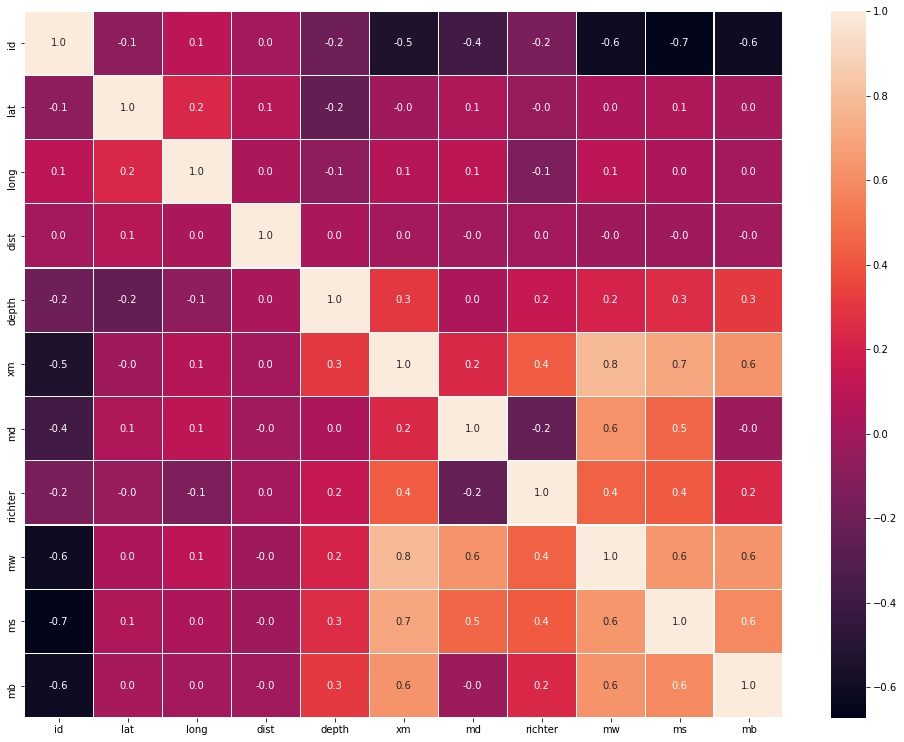

In [6]:
x, ax= plt.subplots(figsize= (17,13))
sns.heatmap(df.corr(), annot= True, 
            linewidths= .2, fmt= ".1f", ax=ax)
plt.show()

In [7]:
pd.options.mode.chained_assignment = None 
for i in range(len(df)):
        if math.isnan(df["mw"].iloc[i]):
            df["mw"].iloc[i] = df["xm"].iloc[i]

df.head()

,id,date,time,lat,long,country,city,area,direction,dist,depth,xm,md,richter,mw,ms,mb
0,2.000000e+13,2003.05.20,12:17:44 AM,39.04,40.38,turkey,bingol,baliklicay,west,0.1,10.0,4.1,4.1,0.0,4.1,0.0,0.0
1,2.010000e+13,2007.08.01,12:03:08 AM,40.79,30.09,turkey,kocaeli,bayraktar_izmit,west,0.1,5.2,4.0,3.8,4.0,4.0,0.0,0.0
2,1.980000e+13,1978.05.07,12:41:37 AM,38.58,27.61,turkey,manisa,hamzabeyli,south_west,0.1,0.0,3.7,0.0,0.0,3.7,0.0,3.7
3,2.000000e+13,1997.03.22,12:31:45 AM,39.47,36.44,turkey,sivas,kahvepinar_sarkisla,south_west,0.1,10.0,3.5,3.5,0.0,3.5,0.0,0.0
4,2.000000e+13,2000.04.02,12:57:38 AM,40.80,30.24,turkey,sakarya,meseli_serdivan,south_west,0.1,7.0,4.3,4.3,0.0,4.3,0.0,0.0


In [8]:
def yeardate(df):
    return df[0:4]
def monthdate(df):
    return df[5:7]
def daydate(df):
    return df[8:10]

df["yeardate"] = df.date.apply(yeardate)
df['yeardate'] = df.yeardate.astype(int)

df["monthdate"] = df.date.apply(monthdate)
df['monthdate'] = df.monthdate.astype(int)

df["daydate"] = df.date.apply(daydate)
df['daydate'] = df.daydate.astype(int)

#Datetime version: 2021-01-21 22:30:31.943988

df["period"] = df["yeardate"].astype(str) + "-" +df["monthdate"].astype(str) + "-" +df["daydate"].astype(str) + " " + df["time"]
df.period = pd.to_datetime(df.period)
df.head()


,id,date,time,lat,long,country,city,area,direction,dist,depth,xm,md,richter,mw,ms,mb,yeardate,monthdate,daydate,period
0,2.000000e+13,2003.05.20,12:17:44 AM,39.04,40.38,turkey,bingol,baliklicay,west,0.1,10.0,4.1,4.1,0.0,4.1,0.0,0.0,2003,5,20,2003-05-20 00:17:44
1,2.010000e+13,2007.08.01,12:03:08 AM,40.79,30.09,turkey,kocaeli,bayraktar_izmit,west,0.1,5.2,4.0,3.8,4.0,4.0,0.0,0.0,2007,8,1,2007-08-01 00:03:08
2,1.980000e+13,1978.05.07,12:41:37 AM,38.58,27.61,turkey,manisa,hamzabeyli,south_west,0.1,0.0,3.7,0.0,0.0,3.7,0.0,3.7,1978,5,7,1978-05-07 00:41:37
3,2.000000e+13,1997.03.22,12:31:45 AM,39.47,36.44,turkey,sivas,kahvepinar_sarkisla,south_west,0.1,10.0,3.5,3.5,0.0,3.5,0.0,0.0,1997,3,22,1997-03-22 00:31:45
4,2.000000e+13,2000.04.02,12:57:38 AM,40.80,30.24,turkey,sakarya,meseli_serdivan,south_west,0.1,7.0,4.3,4.3,0.0,4.3,0.0,0.0,2000,4,2,2000-04-02 00:57:38


In [9]:
df.drop(['date','country', 'area', 'direction', 'dist','time'], axis=1, inplace=True)

In [10]:
df.head()

,id,lat,long,city,depth,xm,md,richter,mw,ms,mb,yeardate,monthdate,daydate,period
0,2.000000e+13,39.04,40.38,bingol,10.0,4.1,4.1,0.0,4.1,0.0,0.0,2003,5,20,2003-05-20 00:17:44
1,2.010000e+13,40.79,30.09,kocaeli,5.2,4.0,3.8,4.0,4.0,0.0,0.0,2007,8,1,2007-08-01 00:03:08
2,1.980000e+13,38.58,27.61,manisa,0.0,3.7,0.0,0.0,3.7,0.0,3.7,1978,5,7,1978-05-07 00:41:37
3,2.000000e+13,39.47,36.44,sivas,10.0,3.5,3.5,0.0,3.5,0.0,0.0,1997,3,22,1997-03-22 00:31:45
4,2.000000e+13,40.80,30.24,sakarya,7.0,4.3,4.3,0.0,4.3,0.0,0.0,2000,4,2,2000-04-02 00:57:38


In [11]:
df.corr()

,id,lat,long,depth,xm,md,richter,mw,ms,mb,yeardate,monthdate,daydate
id,1.000000,-0.071851,0.104695,-0.201035,-0.535262,-0.379838,-0.152355,-0.524702,-0.672286,-0.611488,0.990309,0.028854,0.012129
lat,-0.071851,1.000000,0.232346,-0.241904,-0.010347,0.051100,-0.032155,-0.010366,0.056228,0.015019,-0.064922,0.004853,0.000025
long,0.104695,0.232346,1.000000,-0.064886,0.071856,0.107302,-0.140393,0.078970,0.043574,0.003432,0.105383,0.045166,0.004983
depth,-0.201035,-0.241904,-0.064886,1.000000,0.302926,0.042542,0.150559,0.270426,0.260246,0.313953,-0.204122,-0.012269,-0.009948
xm,-0.535262,-0.010347,0.071856,0.302926,1.000000,0.241432,0.426653,0.879499,0.699579,0.628382,-0.542359,-0.000177,0.003945
md,-0.379838,0.051100,0.107302,0.042542,0.241432,1.000000,-0.237586,0.250319,0.461104,-0.022863,-0.385794,-0.007479,-0.029486
richter,-0.152355,-0.032155,-0.140393,0.150559,0.426653,-0.237586,1.000000,0.331258,0.419664,0.240694,-0.150514,-0.007377,0.031128
mw,-0.524702,-0.010366,0.078970,0.270426,0.879499,0.250319,0.331258,1.000000,0.622337,0.581108,-0.525330,-0.009097,0.001611
ms,-0.672286,0.056228,0.043574,0.260246,0.699579,0.461104,0.419664,0.622337,1.000000,0.588919,-0.675958,-0.016171,0.004676
mb,-0.611488,0.015019,0.003432,0.313953,0.628382,-0.022863,0.240694,0.581108,0.588919,1.000000,-0.616031,-0.010351,0.004209


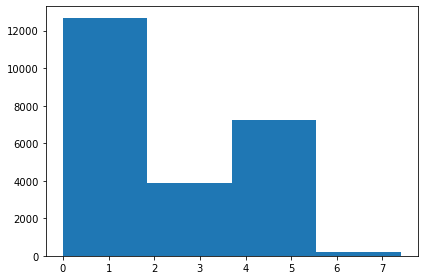

[0.   1.85 3.7  5.55 7.4 ]
[12662.  3886.  7258.   201.]


In [5]:
mag = df.md
(n, bins, patches) = plt.hist(mag, bins = 4)
plt.tight_layout()
plt.show()
print(bins)
print(n)

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 

In [13]:
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,
            urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = df["long"].tolist()
latitudes = df["lat"].tolist()
#m = Basemap(width=12000000,height=9000000,projection='lcc',
            #resolution=None,lat_1=80.,lat_2=55,lat_0=80,lon_0=-107.)
x,y = m(longitudes,latitudes)

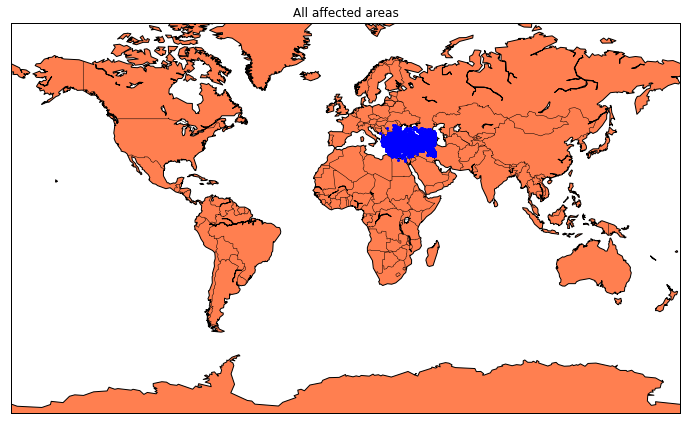

In [14]:
fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='white')
m.drawmapboundary()
m.drawcountries()
plt.show()

In [15]:
def drawmap(df, zoom=1):
    z= (10/3)-(1/3)*zoom
    m = Basemap(projection = 'merc',llcrnrlat=df.lat.min()-z, urcrnrlat=df.lat.max()+z, 
                llcrnrlon=df.long.min()-z, urcrnrlon=df.long.max()+z)
    x,y = m(list(df.long),list(df.lat))
    m.scatter(x,y, c = df.md, cmap = 'seismic')
    m.colorbar()
    m.drawcoastlines()
    #m.drawstates()
    #m.drawcountries()
    m.bluemarble()
    plt.show()
    plt.clf()

In [16]:
over4 = df[df.md >= 4]

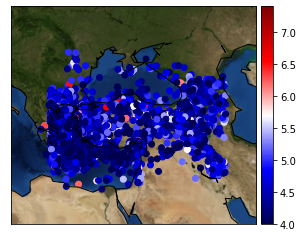

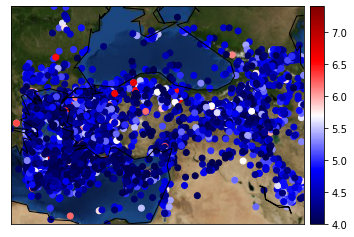

<Figure size 432x288 with 0 Axes>

In [17]:
drawmap(over4, zoom = -3)
drawmap(over4, zoom = 10)

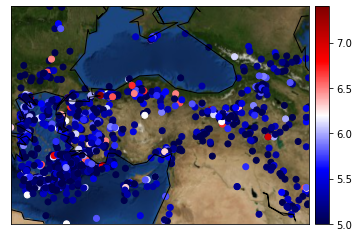

<Figure size 432x288 with 0 Axes>

In [18]:
over5 = df[df.md >= 5]
drawmap(over5, zoom = 10)

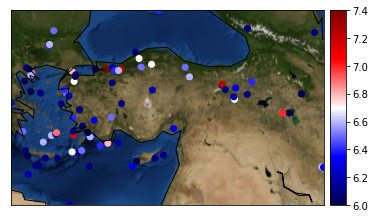

<Figure size 432x288 with 0 Axes>

In [19]:
over6 = df[df.md >= 6]
drawmap(over6, zoom = 10)

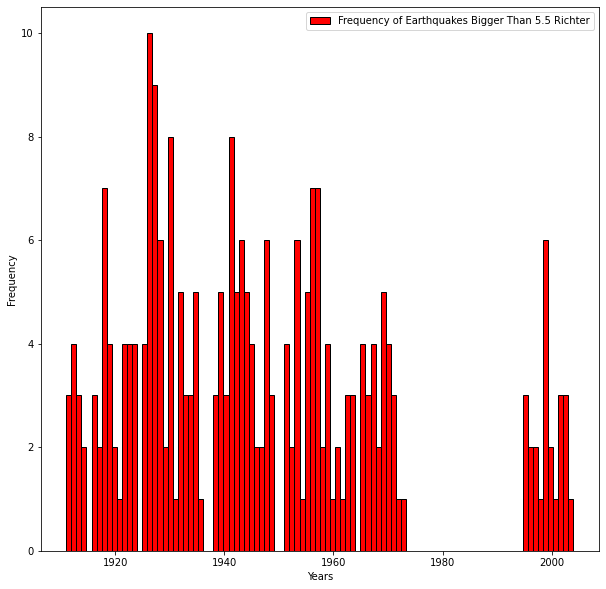

In [20]:
eq_big = df[(df.md >= 5.5)]
eq_big.yeardate.plot(kind = "hist" , color = "red" , edgecolor="black", bins = 100 , figsize = (10,10) , label = "Frequency of Earthquakes Bigger Than 5.5 Richter")
plt.legend(loc = "upper right")
plt.xlabel("Years")
plt.show()

In [21]:
eq_big['city'].unique()

array(['aydin', 'duzce', 'hatay', 'tokat', 'mus', 'burdur', 'bingol',
       'usak', 'denizli', 'osmaniye', 'sakarya', 'erzincan', 'giresun',
       'samsun', 'kastamonu', 'manisa', 'yozgat', 'kutahya', 'cankiri',
       'mugla', 'sivas', 'amasya', 'bursa', 'ardahan', 'adana',
       'eskisehir', 'balikesir', 'izmir', 'adiyaman', 'diyarbakir',
       'kirikkale', 'erzurum', 'karabuk', 'tekirdag', 'kocaeli',
       'canakkale', 'konya', 'kirsehir', 'corum', 'kars', 'agri',
       'afyonkarahisar', 'antalya', 'tunceli', 'bartin', 'istanbul',
       'hakkari', nan, 'gazimagusa'], dtype=object)

In [22]:
df['city'].unique()

array(['bingol', 'kocaeli', 'manisa', 'sivas', 'sakarya', 'mugla', 'van',
       'balikesir', 'kirikkale', 'kahramanmaras', 'adiyaman', 'duzce',
       'antalya', 'kutahya', 'burdur', 'erzincan', 'hatay', 'mus',
       'denizli', 'canakkale', 'bolu', 'tokat', 'sanliurfa', 'corum',
       'izmir', 'gumushane', 'amasya', 'batman', 'cankiri', 'osmaniye',
       'elazig', 'bursa', 'erzurum', 'aydin', 'zonguldak', 'karabuk',
       'samsun', 'malatya', 'tekirdag', 'igdir', 'hakkari', 'ankara',
       'sirnak', 'diyarbakir', 'kirsehir', 'afyonkarahisar', 'kastamonu',
       'bartin', 'konya', 'isparta', 'kars', 'agri', 'bitlis', 'tunceli',
       'istanbul', 'yalova', 'yozgat', 'adana', 'usak', 'edirne',
       'kirklareli', 'mersin', 'bilecik', 'eskisehir', 'gaziantep',
       'bayburt', 'nigde', 'kayseri', 'giresun', 'mardin', 'artvin',
       'aksaray', 'ardahan', 'sinop', 'siirt', 'ordu', 'trabzon', 'kilis',
       'karaman', 'nevsehir', 'rize', nan, 'marmara_denizi', 'lefkosa',
       '

In [23]:
X = df[['yeardate', 'lat', 'long']]
y = df[["md","depth"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(19205, 3) (4802, 3) (19205, 2) (4802, 3)


In [24]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train)
reg.predict(X_test)

reg.score(X_test, y_test)

0.5704706872584697

In [25]:
for i in range(len(df)):
        if df["md"].iloc[i] == 0:
            df["md"].iloc[i] = 0.01

In [26]:
print(df[["md"]])

         md
0      4.10
1      3.80
2      0.01
3      3.50
4      4.30
...     ...
24002  0.01
24003  0.01
24004  0.01
24005  0.01
24006  0.01

[24007 rows x 1 columns]


In [27]:
!python -m pip show scikit-learn  # to see which version and where scikit-learn is installed
!python -m pip freeze  # to see all packages installed in the active virtualenv
!python -c "import sklearn; sklearn.show_versions()"

Name: scikit-learn
Version: 0.24.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: joblib, threadpoolctl, scipy, numpy
Required-by: yellowbrick, umap-learn, textgenrnn, smac, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, imbalanced-learn, fancyimpute, auto-sklearn, resreg
absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
auto-sklearn==0.12.1
autograd==1.3
Babel==2.9.0
backcall==0.2.0
basemap==1.2.2+dev
beautifulsoup4==4.6.3
bleach==3.2.1
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.0
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.4
chainer==7.4.0
chardet==3.0.4
clic

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X = df[['yeardate', 'lat', 'long']]
y = df[["md"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(19205, 3) (4802, 3) (19205, 1) (4802, 3)


In [29]:
import sklearn.datasets
import sklearn.metrics

import autosklearn.regression

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)
automl = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=120,
        per_run_time_limit=30,
        tmp_folder='/tmp/autosklearn_md_tmp',
        output_folder='/tmp/autosklearn_md_out',)

automl.fit(X_train, y_train, dataset_name='earthquake')
print(automl.show_models())
predictions = automl.predict(X_test)

print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))

[(0.560000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'minmax', 'feature_preprocessor:__choice__': 'polynomial', 'regressor:__choice__': 'extra_trees', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.013018052591541176, 'feature_preprocessor:polynomial:degree': 2, 'feature_preprocessor:polynomial:include_bias': 'False', 'feature_preprocessor:polynomial:interaction_only': 'False', 'regressor:extra_trees:bootstrap': 'False', 'regressor:extra_trees:criterion': 'friedman_mse', 'regressor:extra_trees:max_depth': 'None', 'regressor:extra_trees:max_features': 0.9734334465992716, 'regressor:extra_trees:max_leaf_nodes': '

In [36]:
predictions

array([0.01397876, 0.01084254, 4.74413324, ..., 3.83604361, 0.40401361,
       4.81130093])

In [37]:
preds = pd.DataFrame(predictions, columns = ["prediction"])
print(preds)

      prediction
0       0.013979
1       0.010843
2       4.744133
3       4.247197
4       1.049433
...          ...
5997    0.011415
5998    2.829980
5999    3.836044
6000    0.404014
6001    4.811301

[6002 rows x 1 columns]


In [53]:
indexed = a.set_index('new_keys')
print(indexed)

            md
new_keys      
0         0.01
1         0.01
2         4.80
3         4.00
4         0.01
...        ...
5997      0.01
5998      0.01
5999      3.80
6000      0.01
6001      5.80

[6002 rows x 1 columns]


In [55]:
preds["actual"] = indexed["md"]

In [56]:
print(preds)

      prediction  actual
0       0.013979    0.01
1       0.010843    0.01
2       4.744133    4.80
3       4.247197    4.00
4       1.049433    0.01
...          ...     ...
5997    0.011415    0.01
5998    2.829980    0.01
5999    3.836044    3.80
6000    0.404014    0.01
6001    4.811301    5.80

[6002 rows x 2 columns]


In [61]:
#OK, let's do a manual accuracy score, because we can do it.
#Also, I wanted to do manually, just to study

#absolute difference to show
preds["difference"] =abs(preds['prediction'].sub(preds['actual'], axis = 0))

preds

,prediction,actual,difference
0,0.013979,0.01,0.003979
1,0.010843,0.01,0.000843
2,4.744133,4.80,0.055867
3,4.247197,4.00,0.247197
4,1.049433,0.01,1.039433
...,...,...,...
5997,0.011415,0.01,0.001415
5998,2.829980,0.01,2.819980
5999,3.836044,3.80,0.036044
6000,0.404014,0.01,0.394014


In [67]:
#Actual mean squared error
mse = (preds["difference"]**2).mean(axis = 0)
print(mse)

0.7081254825365683


In [69]:
math.sqrt(mse)

0.8415019206968979